# Prepare tensorflow-model-optimization

In [1]:
! pip uninstall -y tensorflow
! pip uninstall -y tf-nightly
! pip install -U tensorflow-gpu==1.14.0

! pip install tensorflow-model-optimization

Uninstalling tensorflow-2.2.0rc1:
  Successfully uninstalled tensorflow-2.2.0rc1
     |████████████████████████████████| 377.0MB 36kB/s 
     |████████████████████████████████| 491kB 51.5MB/s 
     |████████████████████████████████| 3.2MB 63.5MB/s 
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
     |████████████████████████████████| 102kB 4.0MB/s 


In [1]:
%load_ext tensorboard
import tensorboard
import tensorflow as tf
tf.enable_eager_execution()

import tempfile
import zipfile
import os

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

#Download dataset from Google Drive

In [2]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#https://drive.google.com/open?id=1swPiOWtQ80zWHOK0pyWDuhilhRDkFux8/view?usp=sharing
#https://drive.google.com/open?id=1swPiOWtQ80zWHOK0pyWDuhilhRDkFux8
download = drive.CreateFile({'id': '1swPiOWtQ80zWHOK0pyWDuhilhRDkFux8'})
download.GetContentFile('weed_dataset_w25.hdf5')

# Read Dataset

In [0]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from operator import truediv
import h5py
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, cohen_kappa_score, confusion_matrix

import tensorboard
import tensorflow as tf
tf.enable_eager_execution()

import tempfile
import zipfile
import os


In [5]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
LOAD HDF5 FILE
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

hdf5_file = h5py.File('weed_dataset_w25.hdf5', "r")
train_x = np.array(hdf5_file["train_img"][...])
# train_x = train_x / np.max(train_x)
# train_x = np.clip(train_x, 0, 1)
#train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3], 1))
train_y = np.array(hdf5_file["train_labels"][...])

# Average consecutive bands
img2 = np.zeros((train_x.shape[0], train_x.shape[1], train_x.shape[2], int(train_x.shape[3]/2)))
for n in range(0, train_x.shape[0]):
    # Average consecutive bands
    for i in range(0, train_x.shape[3], 2):
        img2[n, :, :, int(i/2)] = (train_x[n, :, :, i] + train_x[n, :, :, i + 1]) / 2.

train_x = img2

print(train_x.shape)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3], 1))

(6316, 25, 25, 150)


# Calculate loss after removing one spectral band

In [6]:
data = 'WEED'
windowSize = train_x.shape[1]
classes = 3

tf.keras.backend.clear_session()
# Load trained pruned network
#loaded_model = tf.keras.models.load_model("Kochia_hyper3DNet_pruned.h5")

# Load model without pruning
loaded_model = tf.keras.models.load_model("weights-hyper3dnetWEED1-best_3layers_4filters.h5")

loaded_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer='adadelta',
        metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
import pickle
from tensorflow_model_optimization.sparsity import keras as sparsity

windowSize = train_x.shape[1]
classes = 3
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

epochs = 8
batch_size = 32;
num_train_samples = train_x.shape[0]
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs

data = 'WEED'
SA = np.zeros((10, train_x.shape[3],))
ntrain = 1
for train, test in kfold.split(train_x, train_y):

    loaded_model.load_weights("weights-hyper3dnet" + data + str(ntrain) + "-best_3layers_4filters.h5")

    ytest = tf.keras.utils.to_categorical(train_y[test]).astype(np.int32) 
    ypred1 = loaded_model.predict(train_x[test])
    loss1 = tf.keras.losses.categorical_crossentropy(ytest, ypred1)
    print("Fold:" + str(ntrain) +" , original accuracy: " + str(np.sum(ypred1*ytest)/len(ytest)))
    for nchannel in range(0, train_x.shape[3]):
      xtest = train_x[test].copy()
      xtest[:, :, :, nchannel, :] = np.zeros((train_x[test].shape[0], train_x.shape[1], train_x.shape[2], 1))
      ypred2 = loaded_model.predict(xtest)
      loss2 = tf.keras.losses.categorical_crossentropy(ytest, ypred2)
      print("Analyzing channel " +str(nchannel) + ": " + str(np.sum(ypred2*ytest)/len(ytest)))
      SA[ntrain-1][nchannel] = np.sum(abs(loss2 - loss1))

    with open('SA_fold_pruning'+str(ntrain), 'wb') as f:
      pickle.dump(SA[ntrain-1], f)

    ntrain += 1;

Fold:1 , original accuracy: 0.9866267883519442
Analyzing channel 0: 0.847954113334231
Analyzing channel 1: 0.6468816822558374
Analyzing channel 2: 0.3696855276741364
Analyzing channel 3: 0.4501513286922669
Analyzing channel 4: 0.5021115991479826
Analyzing channel 5: 0.5330908738492727
Analyzing channel 6: 0.6080368710795311
Analyzing channel 7: 0.6438414066609932
Analyzing channel 8: 0.25429710093844715
Analyzing channel 9: 0.19824072823030986
Analyzing channel 10: 0.19950297878315656
Analyzing channel 11: 0.4119390702443211
Analyzing channel 12: 0.4611847629202516
Analyzing channel 13: 0.5526227484297913
Analyzing channel 14: 0.44431974883520814
Analyzing channel 15: 0.4954573849480621
Analyzing channel 16: 0.3790646631536575
Analyzing channel 17: 0.3568051824783805
Analyzing channel 18: 0.7535665742076404
Analyzing channel 19: 0.5781908756975415
Analyzing channel 20: 0.3875639675735459
Analyzing channel 21: 0.4306245196070006
Analyzing channel 22: 0.5390925160339105
Analyzing channel

No handles with labels found to put in legend.


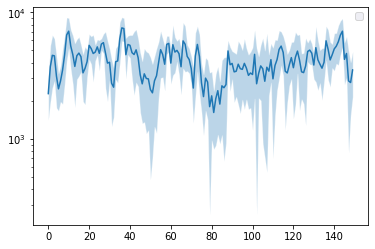

In [10]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

means = np.mean(SA, axis=0)
stds = np.std(SA, axis=0)

fig, ax = plt.subplots()
clrs = sns.color_palette()
with sns.axes_style("darkgrid"):
    epochs = list(range(150))
    
    ax.plot(epochs, means, c=clrs[0])
    ax.fill_between(epochs, means-stds, means+stds ,alpha=0.3, facecolor=clrs[0])
    ax.legend()
    ax.set_yscale('log')

plt.savefig('Bands_importance_plotKochiahyper3dnet_crossvalidation_nopruning.png', dpi=1200)



Printing saliency and spectral band
Spectral band: 36	Saliency: 7550.397509765625
Spectral band: 37	Saliency: 7460.240478515625
Spectral band: 10	Saliency: 7114.1141357421875
Spectral band: 144	Saliency: 7110.904541015625
Spectral band: 9	Saliency: 6633.272198486328
Spectral band: 143	Saliency: 6616.896044921875
Spectral band: 35	Saliency: 6168.446362304688
Spectral band: 136	Saliency: 5967.235498046875
Spectral band: 66	Saliency: 5955.474755859375
Spectral band: 142	Saliency: 5869.88154296875
Spectral band: 27	Saliency: 5770.404150390625
Spectral band: 59	Saliency: 5692.368334960937
Spectral band: 26	Saliency: 5617.664794921875
Spectral band: 67	Saliency: 5598.956884765625
Spectral band: 58	Saliency: 5593.209033203125
Spectral band: 73	Saliency: 5586.362646484375
Spectral band: 39	Saliency: 5581.03564453125
Spectral band: 61	Saliency: 5557.762182617187
Spectral band: 40	Saliency: 5496.787939453125
Spectral band: 20	Saliency: 5491.80673828125
Spectral band: 11	Saliency: 5423.61083984

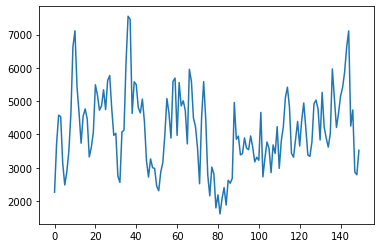

In [11]:
list_importance = list(zip(means, range(0, 150)))
sortedlist = sorted(list_importance, key = lambda x: x[0], reverse=True)
print('\n\nPrinting saliency and spectral band')
for x in sortedlist: 
    print("Spectral band: " + str(x[1]) + "\tSaliency: " + str(x[0])) 

import matplotlib.pyplot as plt
plt.plot(means)

0.28526645302897086
0.3213106108591115


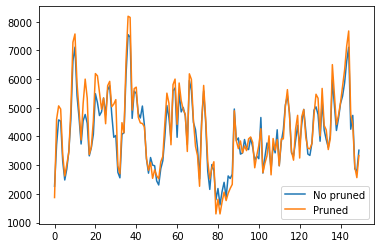

In [16]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

SA2 = np.zeros((10, 150,))

for i in range(0, 10):
      with open('SA_fold_pruning' + str(i + 1), 'rb') as f:
          SA2[i][:] = pickle.load(f)

means2 = np.mean(SA2, axis=0)
stds2 = np.std(SA2, axis=0)

import matplotlib.pyplot as plt
l1, = plt.plot(means, label='No pruned')
l2, = plt.plot(means2, label='Pruned')
plt.legend(handles=[l1, l2])
plt.savefig('Bands_importance_plotKochiahyper3dnet_crossvalidation_means_comparison.png', dpi=1200)

coef_variation1 = np.std(means)/np.mean(means)
print(coef_variation1)
coef_variation2 = np.std(means2)/np.mean(means2)
print(coef_variation2)